In [5]:
%matplotlib inline
from IPython.display import HTML
from IPython.display import display, Markdown


HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# JPA Project

In this notebook, we present the experimental and theoretical derivations from the study of a Josephson Parametric Amplifier (JPA).

We have the following experimental set-up.

<br>

<div>
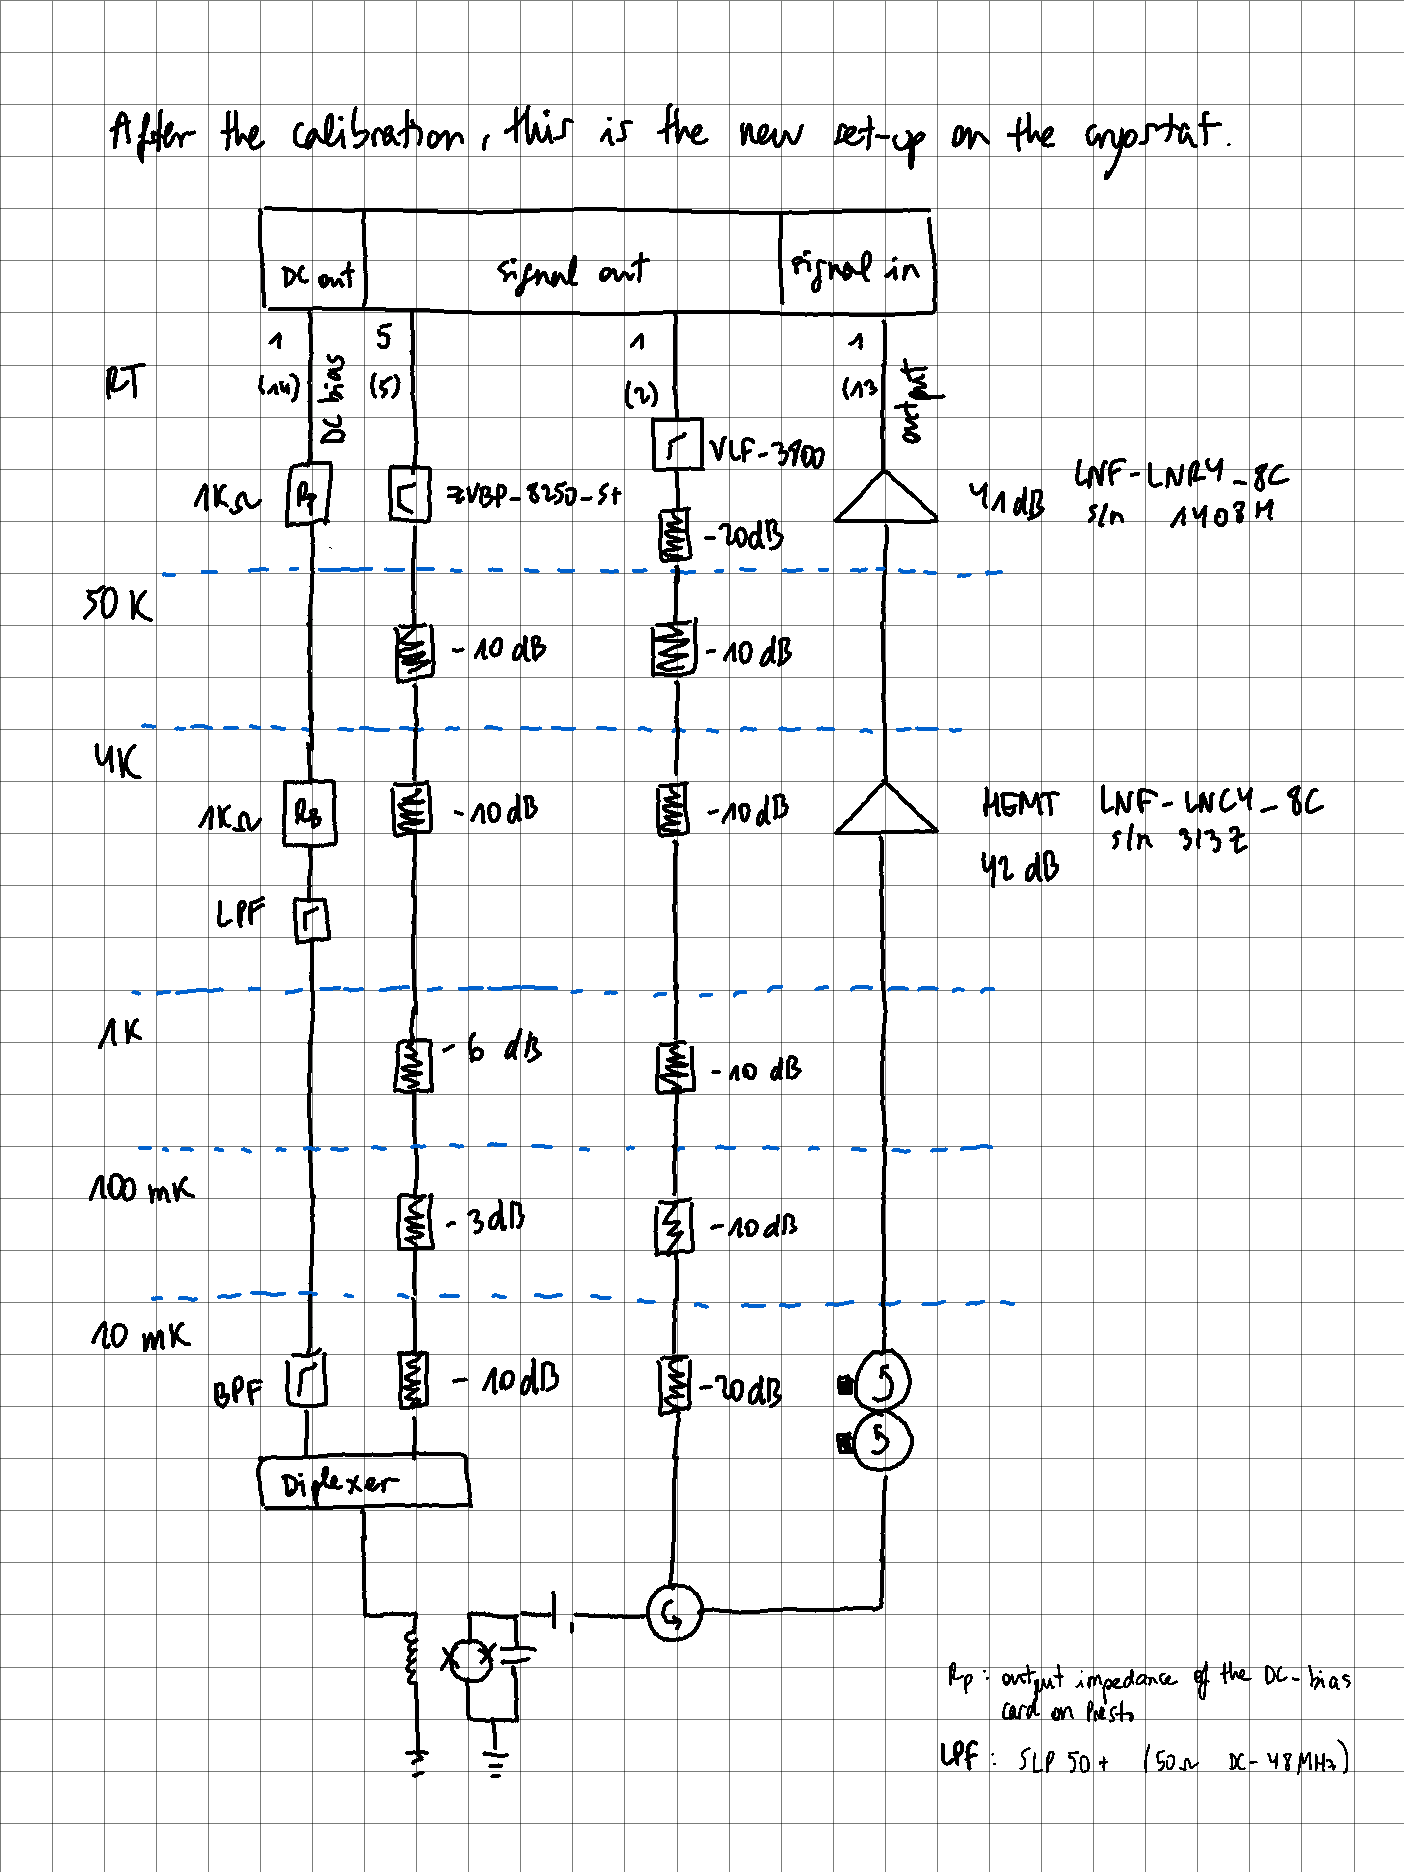
</div>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import h5py

plt.rcParams['axes.formatter.useoffset'] = False
plt.rcParams['figure.constrained_layout.use'] = True

## Modulation curve

The first measurement we perform is a 2D frequency and DC bias sweep to obtain the modulation curve of the JPA.
For this measurement, we use the VNA to probe the JPA and Presto to DC bias it.


In [2]:
def dB(Sjk):
    return 20 * np.log10(np.abs(Sjk))


def plotSjk(farr, Sjk):
    plt.plot(farr / 1e9, dB(Sjk), 'darkred')
    plt.grid(True)
    plt.xlabel('f [GHz]')
    plt.ylabel('$S_{11}$[dB]')


def groupdelayFromS(freqarr, Sjk, windowSize=3):

    df = np.mean(np.diff(freqarr))
    phase = np.unwrap(np.angle(Sjk))
    smoothphase = np.zeros((len(bias_arr), len(freq_arr) - 2))
    for idx in range(len(phase[:, 0])):
        smoothphase[idx] = np.convolve(phase[idx, :], np.ones((windowSize,)) / windowSize, mode='valid')
    gd_ = np.abs(np.diff(smoothphase, axis=1) / 2 / np.pi / df) * 1e9

    lendiff = len(freqarr) - len(gd_[0])

    freq_gd_ = freqarr[:-lendiff] + df * lendiff / 2

    return {'freq_gd': freq_gd_, 'gd': gd_, 'phasegd': smoothphase}


def plotgd(groupdelay, x_arr, y_arr, figure, axis, label):
    xmin, xmax = np.min(x_arr), np.max(x_arr) + 0.01
    ymin, ymax = np.min(y_arr) / 1e9, np.max(y_arr) / 1e9
    zmax = 65
    zmin = 50

    a = axis.imshow(groupdelay.T,
                    origin="lower",
                    aspect="auto",
                    extent=[xmin, xmax, ymin, ymax],
                    vmin=zmin,
                    vmax=zmax,
                    cmap="Spectral",
                    interpolation=None,
                    )

    figure.colorbar(a, label="Group delay [ns]")

    if label == 'flux':
        axis.set_xlabel("$\Phi/\Phi_0$")
    else:
        axis.set_xlabel("DC bias [V]")
    axis.set_ylabel("Frequency [GHz]")

In [3]:
# Load data
file = r'D:\JPA\JPA-Data\QuantumGarage-JPA.hdf5'
cooldown = '2022-06-30'
run = '2022-06-30_10_46_33'
idx_str = "{}/{}".format(cooldown, run)

# Open hdf5 file
with h5py.File(file, "r") as dataset:
    # Data
    freq_arr = np.asarray(dataset[idx_str]["freq_arr"])
    bias_arr = np.asarray(dataset[idx_str]["bias_arr"])
    S11_arr = np.asarray(dataset[idx_str]["s11_arr"])

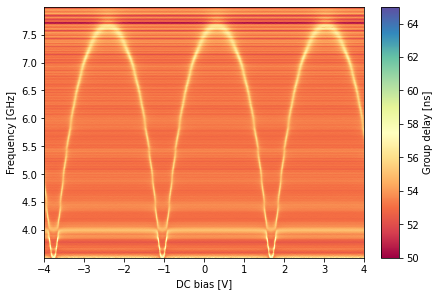

In [6]:
# Group delay
group_delay = groupdelayFromS(freq_arr, S11_arr)
gd = group_delay['gd']
freq_gd = group_delay['freq_gd']

# Plot group delay
fig0, ax0 = plt.subplots(1)
plotgd(gd, bias_arr, freq_gd, fig0, ax0, 'bias')

From the modulation curve one can calculate the mutual inductance of the SQUID as:

$$ M = R_B \dfrac{\Phi_0}{\Delta V} = 1000 \Omega \: \dfrac{2.065 \cdot 10^{-15} \text{Wb}}{2.7 \text{V}} = 0.77 \text{pH} $$

With the estimate of the mutual inductance, we can convert the x-axis of the previous figure to flux instead of voltage.

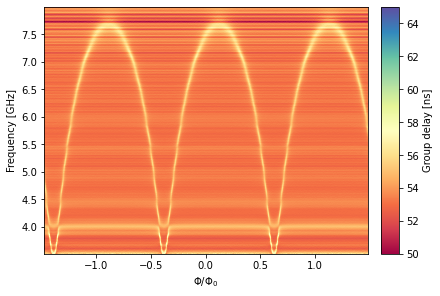

In [7]:
# Parameters values
M = 7.65e-13  # H
Rb = 1000  # Ohm
Flux_quanta = 2.07e-15  # Wb

# Flux in terms of the flux quanta
flux_arr = M / Rb * bias_arr / Flux_quanta

# Plot group delay as a function of flux
fig1, ax1 = plt.subplots(1)
plotgd(gd, flux_arr, freq_gd, fig1, ax1, 'flux')

# # Group delay at a given dc bias value
# bias_idx = 555
# fig2, ax2 = plt.subplots(1)
# ax2.plot(freq_gd / 1e9, gd[bias_idx])
# ax2.set_xlabel('frequency [GHz]')
# ax2.set_ylabel('group delay [ns]')
# ax2.set_title('DC bias ' + f'= {bias_arr[bias_idx]:.3f} V')

## Gain

The next step is to get gain out of the JPA.
To do so, we first estimate how much power we need on the flux line to be able to get gain out of the system.
After some math we obtain that such power is given by

$$ P = \dfrac{Z_0}{2} \left( \dfrac{\gamma}{M}\dfrac{\partial\phi}{\partial\omega_0} \right)^2 = -102 \text{dBm} $$

In [8]:
def plot_gain_cut(gain, farr, pump_val, bias_val, axis):
    axis.plot(farr / 1e9, gain, label=f'{pump_val:.3f} fsu')
    axis.set_title(r'DC bias ' + f'= {bias_val:.3f} V')
    axis.set_xlabel('frequency [GHz]')
    axis.set_ylabel('gain [dB]')


def plot_gain(gain, x_arr, y_arr, figure, axis):
    xmin, xmax = np.min(x_arr), np.max(x_arr)
    ymin, ymax = np.min(y_arr) / 1e9, np.max(y_arr) / 1e9

    cutoff = 0.01
    zmin = np.percentile(gain, cutoff)
    zmax = np.percentile(gain, 100. - cutoff)

    a = axis.imshow(gain.T,
                    origin="lower",
                    aspect="auto",
                    extent=[xmin, xmax, ymin, ymax],
                    vmin=zmin,
                    vmax=zmax,
                    cmap="RdBu_r",
                    interpolation=None,
                    )
    figure.colorbar(a, label=r'gain [dB]')
    axis.set_xlabel('DC bias [V]')
    axis.set_ylabel('frequency [GHz]')
    axis.set_title('pump power = ' + f'{pump_pwr_arr[pump_idx]:.3f} fsu')

    plt.show()


def plot_gainsweep(gain_arr_, freq_arr_, bias_arr_):
    nr_rows = 4
    nr_columns = 3
    nr_plots = nr_rows * nr_columns

    n = nr_pump_pwr // nr_plots

    fig, ax = plt.subplots(nr_rows, nr_columns, figsize=[19, 9.5], constrained_layout=True)
    ax = ax.flatten()

    xmin, xmax = np.min(bias_arr_), np.max(bias_arr_)
    ymin, ymax = np.min(freq_arr_) / 1e9, np.max(freq_arr_) / 1e9

    cutoff = 0.01  # %
    zmin = np.percentile(gain_arr_, cutoff)
    zmax = np.percentile(gain_arr_, 100. - cutoff)

    for axi in range(nr_plots):
        amp_ind = n * axi
        a = ax[axi].imshow(gain_arr_[amp_ind].T,
                           origin="lower",
                           aspect="auto",
                           extent=[xmin, xmax, ymin, ymax],
                           vmin=zmin,
                           vmax=zmax,
                           cmap="RdBu_r",
                           interpolation=None,
                           )
        ax[axi].set_title(r'$A_p$' + f' = {pump_pwr_arr[amp_ind + 1]:.3f} fsu')
        ax[axi].axvline(x=bias_arr_[bias_idx], linestyle='--', color='black')
    fig.colorbar(a, ax=ax[:], location='right', label=r'gain [dB]', shrink=0.6)
    [ax[axi].set_xlabel('DC bias [V]') for axi in [9, 10, 11]]
    [ax[axi].set_ylabel('Frequency [GHz]') for axi in [0, 3, 6, 9]]

    plt.show()

In [9]:
# Load data
file = r'D:\JPA\JPA-Data\QuantumGarage-JPA.hdf5'
cooldown = r'2022-06-30'
run = '2022-07-01_12_00_50'
idx_str = "{}/{}".format(cooldown, run)

# Open hdf5 file
with h5py.File(file, "r") as dataset:
    # Attributes
    df = dataset[idx_str].attrs["df"]

    # Data
    freq_arr = np.asarray(dataset[idx_str]["freq sweep"])
    pump_pwr_arr = np.asarray(dataset[idx_str]["pump pwr sweep"])
    bias_arr = np.asarray(dataset[idx_str]["bias sweep"])
    usb_arr = np.asarray(dataset[idx_str]["USB"])

nr_pump_pwr = len(pump_pwr_arr)
nr_bias = len(bias_arr)

# Load data    
run = '2022-07-04_09_46_55'
idx_str = "{}/{}".format(cooldown, run)

# Open hdf5 file
with h5py.File(file, "r") as dataset:
    # Attributes
    df_ref = dataset[idx_str].attrs["df"]
    bias_ref = dataset[idx_str].attrs["DC bias"]

    # Data
    freq_ref_arr = np.asarray(dataset[idx_str]["freq sweep"])
    usb_ref_arr = np.asarray(dataset[idx_str]["USB"])

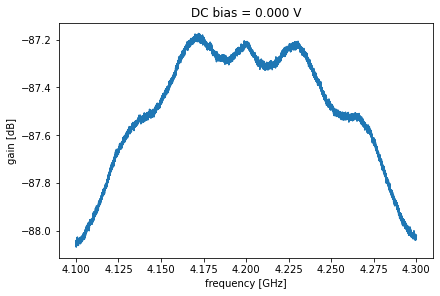

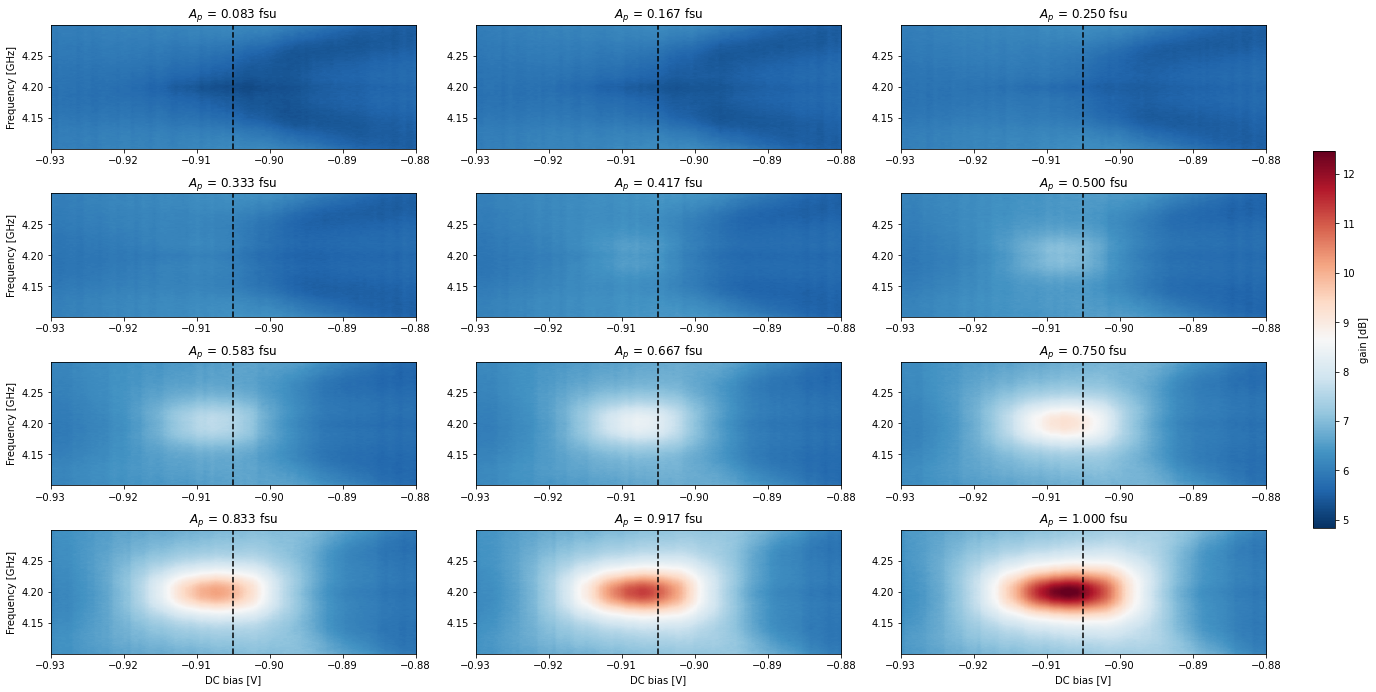

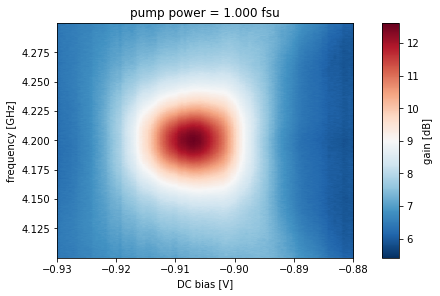

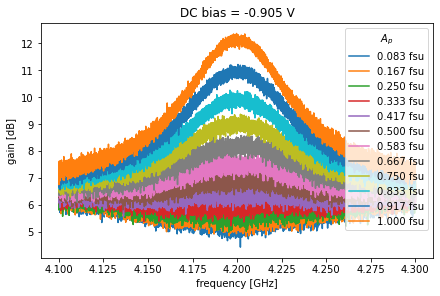

In [11]:
bias_idx = 50

# Gain normalised
gain_ref = dB(usb_ref_arr) - 20  # Check this (the amplitude in fsu of the reference meas was 10 bigger)
gain_arr = dB(usb_arr[1:]) - gain_ref

# Plot background (no-pump) response
fig0, ax0 = plt.subplots(1)
plot_gain_cut(gain_ref, freq_arr, 0, bias_ref, ax0)
plt.show()

# Plot gain sweep for all pump powers
plot_gainsweep(gain_arr, freq_arr, bias_arr)

# Plot gain at a given pump power
pump_idx = -1
fig1, ax1 = plt.subplots(1)
plot_gain(gain_arr[pump_idx], bias_arr, freq_arr, fig1, ax1)

# Plot gain at fixed dc bias for all pump powers
fig2, ax2 = plt.subplots(1)
for pump_idx in range(nr_pump_pwr - 1):
    plot_gain_cut(gain_arr[pump_idx, bias_idx], freq_arr, pump_pwr_arr[pump_idx + 1], bias_arr[bias_idx], ax2)
ax2.legend(title=r'$A_p$')
plt.show()